In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, QuantileTransformer

In [2]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [23]:
from pycm import ConfusionMatrix

In [3]:
import warnings

In [4]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import backend as k
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization, AlphaDropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GaussianNoise

from autoencoders import make_conditional_autoencoder

In [5]:
def read_data():
    df = pd.read_parquet("../dataset.parquet")
    categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
    feature_columns = [
        'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
        'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 
        'fst_sale_in_black_friday_days', 'snd_sale_in_black_friday_days'
    ]

    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    df = df.loc[df.waiting_time > 0]

    features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
    X = df.loc[:, features].copy()
    y = df.loc[:, 'has_second_sale_within_year'].copy()


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    qt = QuantileTransformer()
    qt.fit(X_train.loc[:, ["age", "gmv"]])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_train.loc[:, ["age", "gmv"]] = qt.transform(X_train.loc[:, ["age", "gmv"]])
        X_test.loc[:, ["age", "gmv"]] = qt.transform(X_test.loc[:, ["age", "gmv"]])
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = read_data()

In [7]:
n_examples, shape_dim = X_train.shape

In [8]:
mu_encoder = Sequential([
    Dense(16, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(8, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(4, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(2, activation="selu", kernel_initializer='orthogonal'),
])

log_sigma_encoder = Sequential([
    Dense(64, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(32, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(16, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(8, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(4, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(2, activation="selu", kernel_initializer='orthogonal'),
])

decoder = Sequential([
    Dense(4, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(8, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(16, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(16, activation="selu", kernel_initializer='orthogonal'),
    BatchNormalization(),
    Dense(shape_dim, activation="sigmoid", kernel_initializer='orthogonal')
])


vae = make_conditional_autoencoder(
    mu_encoder, log_sigma_encoder, decoder, shape_dim, Nadam())

In [51]:
vae.fit([X_train, y_train], X_train, epochs=400, batch_size=128)

Epoch 1/400
859243/859243 [==============================] - 33s 39us/sample - loss: 9.0443 - reconstruction_loss: 0.1789 - representation_loss: 8.8654
Epoch 2/400
859243/859243 [==============================] - 33s 39us/sample - loss: 9.0434 - reconstruction_loss: 0.1789 - representation_loss: 8.8645
Epoch 3/400
859243/859243 [==============================] - 31s 36us/sample - loss: 9.0470 - reconstruction_loss: 0.1788 - representation_loss: 8.8682
Epoch 4/400
859243/859243 [==============================] - 31s 36us/sample - loss: 9.0450 - reconstruction_loss: 0.1788 - representation_loss: 8.8662
Epoch 5/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0458 - reconstruction_loss: 0.1788 - representation_loss: 8.8670
Epoch 6/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0444 - reconstruction_loss: 0.1788 - representation_loss: 8.8656
Epoch 7/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0

859243/859243 [==============================] - 30s 35us/sample - loss: 9.0446 - reconstruction_loss: 0.1786 - representation_loss: 8.8660
Epoch 55/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0442 - reconstruction_loss: 0.1786 - representation_loss: 8.8656
Epoch 56/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0447 - reconstruction_loss: 0.1786 - representation_loss: 8.8661
Epoch 57/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0438 - reconstruction_loss: 0.1786 - representation_loss: 8.8651
Epoch 58/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0452 - reconstruction_loss: 0.1786 - representation_loss: 8.8666
Epoch 59/400
859243/859243 [==============================] - 31s 36us/sample - loss: 9.0445 - reconstruction_loss: 0.1786 - representation_loss: 8.8659
Epoch 60/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0441 - 

859243/859243 [==============================] - 30s 35us/sample - loss: 9.0449 - reconstruction_loss: 0.1786 - representation_loss: 8.8664
Epoch 108/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0438 - reconstruction_loss: 0.1786 - representation_loss: 8.8652
Epoch 109/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0455 - reconstruction_loss: 0.1786 - representation_loss: 8.8669
Epoch 110/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0447 - reconstruction_loss: 0.1786 - representation_loss: 8.8662
Epoch 111/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0453 - reconstruction_loss: 0.1786 - representation_loss: 8.8667
Epoch 112/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0439 - reconstruction_loss: 0.1786 - representation_loss: 8.8654
Epoch 113/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0

859243/859243 [==============================] - 30s 35us/sample - loss: 9.0447 - reconstruction_loss: 0.1786 - representation_loss: 8.8661
Epoch 161/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0434 - reconstruction_loss: 0.1786 - representation_loss: 8.8648
Epoch 162/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0452 - reconstruction_loss: 0.1786 - representation_loss: 8.8667
Epoch 163/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0437 - reconstruction_loss: 0.1785 - representation_loss: 8.8652
Epoch 164/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0449 - reconstruction_loss: 0.1786 - representation_loss: 8.8663
Epoch 165/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0458 - reconstruction_loss: 0.1786 - representation_loss: 8.8672
Epoch 166/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0

859243/859243 [==============================] - 30s 35us/sample - loss: 9.0439 - reconstruction_loss: 0.1785 - representation_loss: 8.8653
Epoch 214/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0436 - reconstruction_loss: 0.1785 - representation_loss: 8.8650
Epoch 215/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0448 - reconstruction_loss: 0.1785 - representation_loss: 8.8662
Epoch 216/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0444 - reconstruction_loss: 0.1785 - representation_loss: 8.8658
Epoch 217/400
859243/859243 [==============================] - 31s 36us/sample - loss: 9.0459 - reconstruction_loss: 0.1785 - representation_loss: 8.8673
Epoch 218/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0434 - reconstruction_loss: 0.1786 - representation_loss: 8.8648
Epoch 219/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0

859243/859243 [==============================] - 31s 36us/sample - loss: 9.0438 - reconstruction_loss: 0.1786 - representation_loss: 8.8653
Epoch 267/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0428 - reconstruction_loss: 0.1785 - representation_loss: 8.8642
Epoch 268/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0433 - reconstruction_loss: 0.1785 - representation_loss: 8.8648
Epoch 269/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0441 - reconstruction_loss: 0.1786 - representation_loss: 8.8655
Epoch 270/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0440 - reconstruction_loss: 0.1785 - representation_loss: 8.8654
Epoch 271/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0456 - reconstruction_loss: 0.1786 - representation_loss: 8.8671
Epoch 272/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0

859243/859243 [==============================] - 30s 35us/sample - loss: 9.0442 - reconstruction_loss: 0.1785 - representation_loss: 8.8657
Epoch 320/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0452 - reconstruction_loss: 0.1785 - representation_loss: 8.8667
Epoch 321/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0436 - reconstruction_loss: 0.1785 - representation_loss: 8.8650
Epoch 322/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0452 - reconstruction_loss: 0.1785 - representation_loss: 8.8667
Epoch 323/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0450 - reconstruction_loss: 0.1785 - representation_loss: 8.8665
Epoch 324/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0446 - reconstruction_loss: 0.1785 - representation_loss: 8.8660
Epoch 325/400
859243/859243 [==============================] - 31s 36us/sample - loss: 9.0

859243/859243 [==============================] - 30s 35us/sample - loss: 9.0437 - reconstruction_loss: 0.1785 - representation_loss: 8.8651
Epoch 373/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0442 - reconstruction_loss: 0.1785 - representation_loss: 8.8657
Epoch 374/400
859243/859243 [==============================] - 31s 36us/sample - loss: 9.0441 - reconstruction_loss: 0.1785 - representation_loss: 8.8655
Epoch 375/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0429 - reconstruction_loss: 0.1786 - representation_loss: 8.8644
Epoch 376/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0439 - reconstruction_loss: 0.1785 - representation_loss: 8.8653
Epoch 377/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0450 - reconstruction_loss: 0.1785 - representation_loss: 8.8664
Epoch 378/400
859243/859243 [==============================] - 30s 35us/sample - loss: 9.0

In [52]:
z_train = mu_encoder.predict(X_train)
z_test = mu_encoder.predict(X_test)

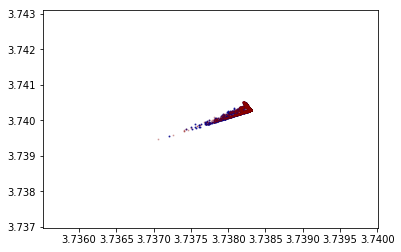

In [53]:
fig, ax = plt.subplots()

ax.scatter(
    z_train[y_train == 0, 0][0:10000],
    z_train[y_train == 0, 1][0:10000],
    color="DarkBlue",
    alpha=0.75,
    s=1
)

ax.scatter(
    z_train[y_train == 1, 0][0:10000],
    z_train[y_train == 1, 1][0:10000],
    color="DarkRed",
    alpha=0.25,
    s=1    
)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics as skmetrics

In [55]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(z_train, y_train)

/home/calsaverini/dev/analysis/survival/second_order/VAE/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
s_pred = clf.predict_proba(z_test)
y_pred = clf.predict(z_test)

In [57]:
print(skmetrics.classification_report(y_test, y_pred))
skmetrics.precision_recall_fscore_support(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.75      0.99      0.85    274794
           1       0.39      0.02      0.03     93454

   micro avg       0.74      0.74      0.74    368248
   macro avg       0.57      0.50      0.44    368248
weighted avg       0.66      0.74      0.64    368248



(array([0.74768008, 0.38634098]),
 array([0.99104056, 0.0165857 ]),
 array([0.85232931, 0.03180596]),
 array([274794,  93454]))

In [58]:
skmetrics.roc_auc_score(y_test, s_pred[:, 1])

0.5796613819733163

In [59]:
clf_2 = RandomForestClassifier(n_jobs=-1)
clf_2.fit(X_train, y_train)

/home/calsaverini/dev/analysis/survival/second_order/VAE/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
s_pred = clf_2.predict_proba(X_test)
y_pred = clf_2.predict(X_test)
print(skmetrics.classification_report(y_test, y_pred))
skmetrics.precision_recall_fscore_support(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.85      0.92      0.89    274794
           1       0.71      0.53      0.60     93454

   micro avg       0.82      0.82      0.82    368248
   macro avg       0.78      0.73      0.75    368248
weighted avg       0.81      0.82      0.82    368248



(array([0.85222677, 0.70533036]),
 array([0.92492194, 0.5284204 ]),
 array([0.88708754, 0.60419165]),
 array([274794,  93454]))

In [61]:
skmetrics.roc_auc_score(y_test, s_pred[:, 1])

0.7995045667135877

In [62]:
cls = MiniBatchKMeans(n_clusters=2)
labels = cls.fit_predict(z_test)

In [63]:
print(skmetrics.classification_report(y_test, labels))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85    274794
           1       0.27      0.00      0.01     93454

   micro avg       0.74      0.74      0.74    368248
   macro avg       0.51      0.50      0.43    368248
weighted avg       0.63      0.74      0.64    368248



In [64]:
cm = ConfusionMatrix(actual_vector=y_test.values, predict_vector=labels)

In [65]:
print(cm)

Predict      0            1            
Actual
0            273845       949          

1            93101        353          





Overall Statistics : 

95% CI                                                            (0.74319,0.74601)
AUNP                                                              0.50016
AUNU                                                              0.50016
Bennett S                                                         0.4892
CBA                                                               0.37503
Chi-Squared                                                       2.07485
Chi-Squared DF                                                    1
Conditional Entropy                                               0.03388
Cramer V                                                          0.00237
Cross Entropy                                                     2.07055
Gwet AC1                                                          0.67079
Hamming Loss               

In [ ]:
l